In [1]:
import torch
import torch.nn.functional as F
import torchvision
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import tifffile as tiff
import cv2
import subprocess as sp
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
SEARCH_BS = False
SEARCH_LR = False

In [3]:
division = 300
resize_img = 50#500
BS_train = 16
if SEARCH_LR:
    BS_train = int(BS_train / 2)
BS_val = BS_train * 4
EPOCHS = 400
LR = 1e-2
NOTEBOOK_NAME = '08_Resnet18_finders_and_fastprogress'
VALID_SPLIT = 0.2

In [4]:
path = Path("../")
data_path = path / "data"
os.listdir(data_path)

['train_images',
 'test_images',
 'train_annotations',
 'train.csv',
 'sample_submission.csv',
 'test.csv',
 'submission.csv']

In [5]:
train_images_path = data_path / "train_images"

In [6]:
train_df = pd.read_csv(data_path / "train.csv")
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


## ResNet 50 UNet

In [7]:
number_of_classes = 2 # 2 classes
number_of_channels = 3

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=number_of_classes, in_ch=number_of_channels):
        super().__init__()

        self.encoder = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        # x_in = torch.tensor(x.clone().detach())
        x_in = x.clone().detach()
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

## Dice coefficient loss

In [8]:
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(1)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()
    dice = (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)
    dice = dice.item()

    return dice

## Dataset and Dataloader

In [9]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

In [10]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, n_classes=2, dim=2000, interpolation=cv2.INTER_LANCZOS4):
    self.dataframe = dataframe
    self.n_classes = n_classes
    self.dim = dim
    self.interpolation = interpolation

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, ix):
    # Get image path from column 'path' in dataframe
    img_path = str(self.dataframe.iloc[ix]['path'])
    # Load image
    img_cv = cv2.imread(img_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    # Resize image
    img_cv_res = cv2.resize(img_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # Normalize image
    img_cv_res_norm = img_cv_res / 255.0
    # Convert to tensor
    img_tensor = torch.from_numpy(img_cv_res_norm).float().permute(2, 0, 1)

    # Get mask
    rle = self.dataframe.iloc[ix]['rle']
    mask_cv = rle2mask(rle, img_cv.shape)
    # Resize mask
    mask_cv_res = cv2.resize(mask_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # One-hot encode mask
    mask_oh = np.eye(2)[mask_cv_res.astype(int)].astype(np.float32)
    # Convert to tensor
    mask_tensor = torch.from_numpy(mask_oh).float().permute(2, 0, 1)
    
    return img_tensor, mask_tensor

In [11]:
train_split, val_split = train_test_split(train_df, test_size=VALID_SPLIT, shuffle=True, random_state=42, stratify=train_df['organ'])
dataset = {
    'train': Dataset(train_split, n_classes=2, dim=resize_img),
    'val': Dataset(val_split, n_classes=2, dim=resize_img),
}

print(f"Había {len(train_df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 351 imágenes en el dataset, lo hemos dividido en 280 imágenes de entrenamiento y 71 imágenes de validación


In [12]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, pin_memory=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_val, pin_memory=True)
}

## Batch size finder

In [13]:
if SEARCH_BS:
    def get_gpu_memory():
        command = "nvidia-smi --query-gpu=memory.total --format=csv"
        memory_total_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
        memory_total_values = [int(x.split()[0]) for i, x in enumerate(memory_total_info)]

        command = "nvidia-smi --query-gpu=memory.free --format=csv"
        memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
        memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]

        command = "nvidia-smi --query-gpu=memory.used --format=csv"
        memory_used_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
        memory_used_values = [int(x.split()[0]) for i, x in enumerate(memory_used_info)]
        return memory_total_values, memory_free_values, memory_used_values
    total, free, used = get_gpu_memory()
    print(f"GPU memory: total: {total} MiB, free: {free} MiB, used: {used} MiB")

In [14]:
if SEARCH_BS:
    model = UNetResnet()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    if torch.cuda.is_available():
        if torch.cuda.device_count() >= 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            model = torch.nn.DataParallel(model)
        else:
            model.cuda()
    else:
        print("Using CPU")

In [15]:
if SEARCH_BS:
    LR = 1e-3
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

In [16]:
if SEARCH_BS:
    def train_loop(dataloader, model, loss_fn, optimizer):
        model.train()
        for (imgs, masks) in dataloader:
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)

            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = criterion(pred_mask, masks)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [17]:
if SEARCH_BS:
    def list_of_posible_batch_sizes(dataset):
        batch_sizes = []
        batch_size = 1
        while batch_size < 2*len(dataset):
            batch_sizes.append(batch_size)
            batch_size *= 2
        batch_sizes.sort(reverse=True)
        return batch_sizes

    BSs = list_of_posible_batch_sizes(dataset['train'])
    BSs

In [18]:
if SEARCH_BS:
    for batchsize_train in BSs:
        print(f"batch size: {batchsize_train}")
        train_dl = torch.utils.data.DataLoader(dataset['train'], batch_size=batchsize_train, shuffle=True, pin_memory=True)
        epochs = 3
        out_of_memory = False
        for t in range(epochs):
            print(f"\tTrain epoch {t} of {epochs}")
            try:
                train_loop(train_dl, model, optimizer, optimizer)
            except Exception as e:
                print(f'Error: {e}')
                out_of_memory = True
                break
        if out_of_memory == False:
            break
        print()
    print(f"Done!, bacth size is {batchsize_train}")

In [19]:
if SEARCH_BS:
    BS_train = batchsize_train
    BS_val = BS_train * 4
    print(f"For {resize_img}x{resize_img} images size, we use batch size of {BS_train} for train and batch size of {BS_val} for validation")

## Search LR

In [20]:
if SEARCH_LR:
    def lr_finder(model, train_dl, loss_fn, device, lr_init=1e-8, lr_end=10, increment=4, beta=0.98):
        num = len(train_dl)-1 # Numero de lrs que vamos a probar
        q = (lr_end/lr_init)**(1/num) # Incremento de lr
        lr = lr_init
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss = 0
        best_loss = 0.
        avg_loss = 0.
        smoothed_avg_losses = []
        lrs = []
        for batch, (imgs, masks) in enumerate(train_dl):
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)

            # Update optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = loss_fn(pred_mask, masks)
            avg_loss = beta * avg_loss + (1-beta) * loss.to("cpu").item()
            smoothed_loss = avg_loss / (1 - beta**(batch+1))
            if increment is not None:
                # Se para si el loss se dispara
                window = 10
                if batch > window and smoothed_avg_losses[-window] > increment * best_loss:
                    return lrs, smoothed_avg_losses
            
            # Se guarda la menor pérdida
            if avg_loss < best_loss or batch==0:
                best_loss = smoothed_loss
            
            # Se guardan los datos
            smoothed_avg_losses.append(smoothed_loss)
            lrs.append(lr)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update lr
            lr *= q

        return lrs, smoothed_avg_losses

In [21]:
if SEARCH_LR:
    model = UNetResnet()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    [lrss, smoothed_avg_losses] = lr_finder(model, train_dl=dataloader['train'], loss_fn = criterion, device=device)

    plt.plot(lrss, smoothed_avg_losses)
    plt.xlabel("lr")
    plt.ylabel("loss")
    plt.xscale("log")
    plt.grid()
    plt.show()

In [22]:
if SEARCH_LR:
    LR = 1e-2

## Train all images

In [25]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_loop(dataloader, model, loss_fn, optimizer, bar, hist, device):
    train_loss, train_dice = [], []
    model.train()
    # for imgs, masks in progress_bar(dataloader['val'], parent=mb):
    for imgs, masks in bar:
        # X and y to device
        imgs, masks = imgs.to(device), masks.to(device)
        # Compute prediction and loss
        pred_mask = model(imgs)
        loss = loss_fn(pred_mask, masks)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update train loss and dice
        dice = dice_coeff(pred_mask, masks)
        train_loss.append(loss.item())
        train_dice.append(dice)
        # Update progress bar
        bar.set_description(f"\t\tloss {np.mean(train_loss):.5f}, dice {np.mean(train_dice):.5f}")
    hist['loss'].append(np.mean(train_loss))
    hist['dice'].append(np.mean(train_dice))
    return hist

def valid_loop(dataloader, model, loss_fn, optimizer, bar, hist, device):
    val_loss, val_dice = [], []
    model.eval()
    with torch.no_grad():
        # for imgs, masks in progress_bar(dataloader['val'], parent=mb):
        for imgs, masks in bar:
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)
            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = loss_fn(pred_mask, masks)
            # Update test loss and dice
            dice = dice_coeff(pred_mask, masks)
            val_loss.append(loss.item())
            val_dice.append(dice)
            # Update progress bar
            bar.set_description(f"\t\tval_loss {np.mean(val_loss):.5f} val_dice {np.mean(val_dice):.5f}")
    hist['val_loss'].append(np.mean(val_loss))
    hist['val_dice'].append(np.mean(val_dice))
    return hist

def fit(model, dataloader, device, epochs=100, lr=3e-4, parallel=False):
    len_int_epochs = len(str(epochs))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=1e-5)
    criterion = torch.nn.BCEWithLogitsLoss()
    best_dice = 0.
    model_folder = path/'models'
    model_full_name = model_folder/ NOTEBOOK_NAME
    schedulerOnPlateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max', 
        factor=0.1, 
        patience=10, 
        verbose=True)
    if torch.cuda.device_count() >= 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        if parallel:
            model = torch.nn.DataParallel(model)
        model.cuda()
    else:
        print("Let's use CPU!")
        model.to(device)
    hist = {'loss': [], 'dice': [], 'val_loss': [], 'val_dice': []}
    for epoch in range(epochs):
        # if not FASTPROGRESS:
        bar = tqdm(dataloader['train'])
        hist = train_loop(dataloader, model, criterion, optimizer, bar, hist, device)

        # if not FASTPROGRESS:
        bar = tqdm(dataloader['val'])
        hist = valid_loop(dataloader, model, criterion, optimizer, bar, hist, device)
        
        if len_int_epochs == 1:
            print(f"Epoch {(epoch+1):01d}/{epochs:01d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")
        elif len_int_epochs == 2:
            print(f"Epoch {(epoch+1):02d}/{epochs:02d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")
        elif len_int_epochs == 3:
            print(f"Epoch {(epoch+1):03d}/{epochs:03d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")
        elif len_int_epochs == 4:
            print(f"Epoch {(epoch+1):04d}/{epochs:04d} loss {hist['loss'][-1]:.5f} dice {hist['dice'][-1]:.5f} val_loss {hist['val_loss'][-1]:.5f} val_dice {hist['val_dice'][-1]:.5f}")

        if hist['val_dice'][-1] > best_dice:
            best_dice = hist['val_dice'][-1]
            model_full_path = model_full_name.with_suffix('.pth')
            # torch.save(model.state_dict(), model_full_path)
            print(f"New best dice: {best_dice:.5f}")
        
        schedulerOnPlateau.step(hist['val_loss'][-1])
    return hist

In [26]:
if not SEARCH_BS and not SEARCH_LR:
    model = UNetResnet()
    EPOCHS = 3
    hist = fit(model, dataloader, device, epochs=EPOCHS, lr=LR, parallel=True)

Let's use 2 GPUs!


		val_loss 10.87755 val_dice -31.08011: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


Epoch 1/3 loss 0.38064 dice 3.84581 val_loss 10.87755 val_dice -31.08011


		val_loss 15.75358 val_dice 28.29255: 100%|██████████| 2/2 [00:03<00:00,  1.58s/it]


Epoch 2/3 loss 0.27088 dice 6.41318 val_loss 15.75358 val_dice 28.29255
New best dice: 28.29255


		val_loss 0.31408 val_dice 4.68080: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]

Epoch 3/3 loss 0.26699 dice 6.67915 val_loss 0.31408 val_dice 4.68080


In [28]:
if not SEARCH_BS and not SEARCH_LR:
    hist_df = pd.DataFrame(hist)
    print(len(hist_df))
else:
    # Empty dataframe
    hist_df = pd.DataFrame()
hist_df.head()

3


,loss,dice,val_loss,val_dice
0,0.380641,3.845807,10.877552,-31.080108
1,0.270881,6.413175,15.753582,28.292546
2,0.266995,6.679147,0.314076,4.680802


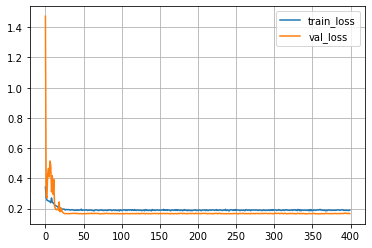

In [28]:
if not SEARCH_BS and not SEARCH_LR:
    # plot the training and testing loss
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.show()

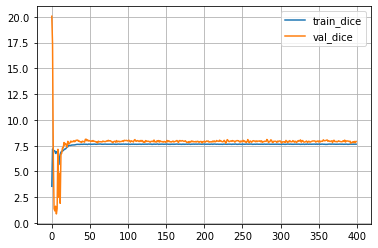

In [29]:
if not SEARCH_BS and not SEARCH_LR:
    # plot the training and testing dice
    plt.plot(hist['dice'], label='train_dice')
    plt.plot(hist['val_dice'], label='val_dice')
    plt.legend()
    plt.grid()
    plt.show()

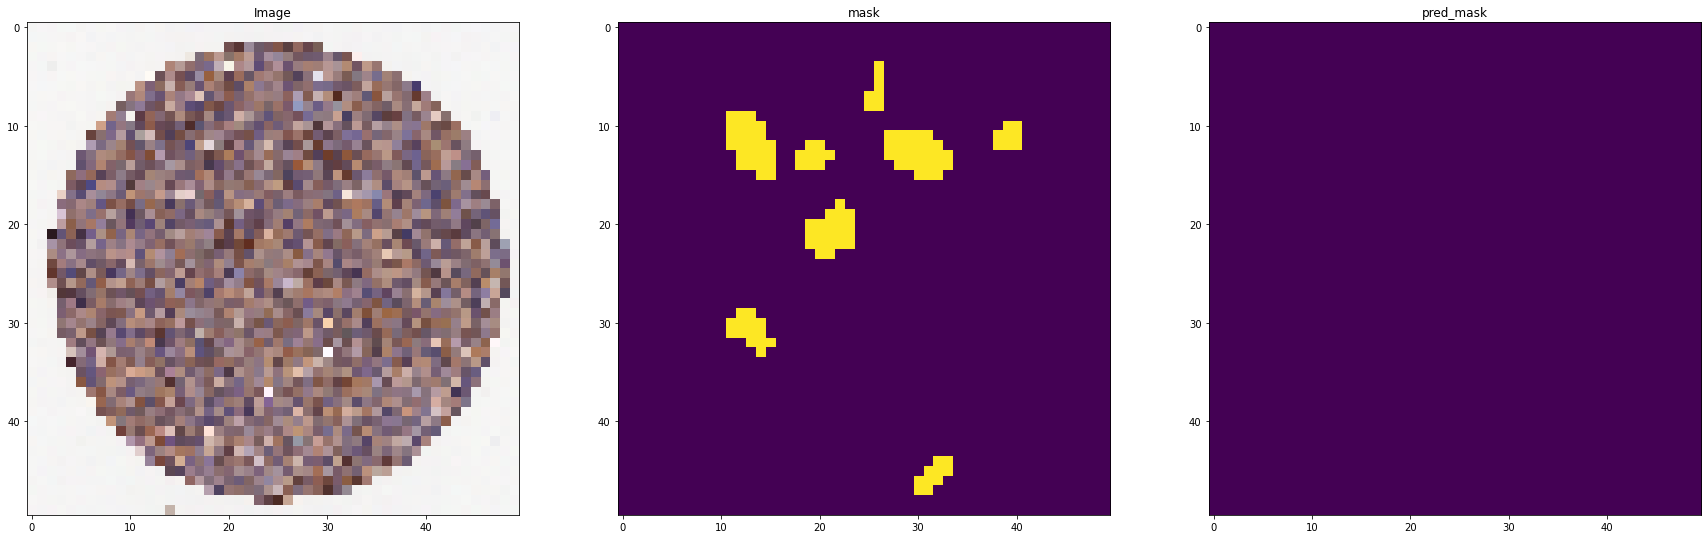

output.shape = torch.Size([2, 50, 50]), pred_mask.shape = (50, 50)


In [39]:
if not SEARCH_BS and not SEARCH_LR:
    sample_val_img, sample_val_mask = next(iter(dataloader['val']))
    one_sample_img = sample_val_img[0]
    one_sample_mask = sample_val_mask[0]
    model.eval()
    with torch.no_grad():
        sample_val_img = sample_val_img.to(device)
        output = model(sample_val_img)[0]
        pred_mask = torch.argmax(output, axis=0)
        pred_mask = pred_mask.type(torch.float32)
        pred_mask = pred_mask.detach().cpu().numpy()
        
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
    ax1.imshow(one_sample_img.permute(1, 2, 0).cpu().numpy())
    ax1.set_title('Image')
    ax2.imshow(torch.argmax(one_sample_mask, axis=0).cpu().numpy())
    ax2.set_title('mask')
    ax3.imshow(pred_mask)
    ax3.set_title('pred_mask')
    plt.show()
    print(f"output.shape = {output.shape}, pred_mask.shape = {pred_mask.shape}")